# Estimating ECM Parameters from Multi-Pulse HPPC Data

This notebook provides example usage for estimating stationary parameters for a two RC branch Thevenin model using multi-pulse HPPC data.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [ ]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q
%pip install openpyxl
%pip install pandas --upgrade

### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import pybamm

import pybop

In this example, we use the default parameter value for the "Open-circuit voltage [V] as provided by the original PyBaMM class. The other relevant parameters for the ECM model implementation are updated as per the cell specification.

In [ ]:
# Load the parameters
parameter_set = pybamm.ParameterValues("ECM_Example")
parameter_set["Cell capacity [A.h]"] = 3
parameter_set["Nominal cell capacity [A.h]"] = 3
parameter_set["Element-1 initial overpotential [V]"] = 0
parameter_set["Upper voltage cut-off [V]"] = 4.2
parameter_set["Lower voltage cut-off [V]"] = 2.5
parameter_set["R0 [Ohm]"] = 0.001
parameter_set["R1 [Ohm]"] = 0.003
parameter_set["C1 [F]"] = 500
parameter_set.update({"R2 [Ohm]": 0.002}, check_already_exists=False)
parameter_set.update({"C2 [F]": 3000}, check_already_exists=False)
parameter_set.update(
    {"Element-2 initial overpotential [V]": 0}, check_already_exists=False
)
parameter_set.update(
    {
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ]
    },
    check_already_exists=False,
)

## Identifying the Parameters

Now that the initial parameter set is constructed, we can start the PyBOP fitting process. First, we define the model class with two RC elements. One important thing here to note is "maximum solver timestep" (dt_max) needs to be set correctly to have a good fit.

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set,
    options={"number of rc elements": 2},
    solver=pybamm.CasadiSolver(mode="safe", dt_max=40),
)

We use multiple HPPC pulses from the dataset: Kollmeyer, Phillip; Skells, Michael (2020), “Samsung INR21700 30T 3Ah Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/9xyvy2njj3.1 

In [ ]:
file_loc = r"../data/Samsung_INR21700/multipulse_hppc.xlsx"
df = pd.read_excel(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(),
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)

In [ ]:
r0_guess = 0.005
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(r0_guess, r0_guess / 10),
        bounds=[0, 0.1],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(500, 100),
        bounds=[100, 1000],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(2000, 500),
        bounds=[1000, 10000],
    ),
)

In [ ]:
# To see current vs time profile.
fig1 = go.Figure()
# Add a line trace for current vs. time
fig1.add_trace(
    go.Scatter(
        x=df["Time"].to_numpy(),
        y=df["Current"].to_numpy(),
        mode="lines",  # 'lines', 'markers', or 'lines+markers'
        name="Current vs Time",
    )
)

# Customize layout
fig1.update_layout(
    title="Current vs Time",
    xaxis_title="Time (s)",
    yaxis_title="Current (A)",
    template="plotly",  # Use a Plotly template (optional)
)

# Show the plot
fig1.show()

In [ ]:
# To see voltage vs time profile.
fig2 = go.Figure()
# Add a line trace for current vs. time
fig2.add_trace(
    go.Scatter(
        x=df["Time"].to_numpy(),
        y=df["Voltage"].to_numpy(),
        mode="lines",  # 'lines', 'markers', or 'lines+markers'
        name="Voltage vs Time",
    )
)

# Customize layout
fig2.update_layout(
    title="Voltage vs Time",
    xaxis_title="Time (s)",
    yaxis_title="Voltage (V)",
    template="plotly",  # Use a Plotly template (optional)
)

# Show the plot
fig2.show()

The `FittingProblem` class provides us with a single class that holds all of the objects we need to evaluate our selected `SumSquaredError` cost function.

Initil state can be either "Initial SoC" or "Initial open-circuit voltage [V]". In this example, we get the initial OCV by accesiing the voltage data. However, user can simply use a vlue instead, e.g., {"Initial open-circuit voltage [V]": 4.1}. Similarly, if SOC input is required, {"Initial SoC": 0.95}.

In [ ]:
problem = pybop.FittingProblem(
    model,
    parameters,
    dataset,
    initial_state={"Initial open-circuit voltage [V]": df["Voltage"].to_numpy()[0]},
)

cost = pybop.SumSquaredError(problem)

The cost function can be interrogated manually via the `cost([params])` API. In this example, that would look like the following,

In [ ]:
cost([0.001, 0.001, 0.001, 5000, 5000])

0.9767591248227608

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the CMA-ES method as it provides global optimisation capability. For the sake of reducing the runtime of this example, we limit the maximum iterations to 100; however, feel free to update this value.

In [ ]:
optim = pybop.CMAES(cost, max_unchanged_iterations=50, max_iterations=300)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [5.69941601e-03 5.04921223e-03 5.03032448e-03 6.82214058e+02
 2.20190016e+03]
Estimated parameters: [1.05840217e-02 3.92306610e-03 2.52965901e-02 6.82206085e+02
 2.20190754e+03]


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualize the results of the optimisation.

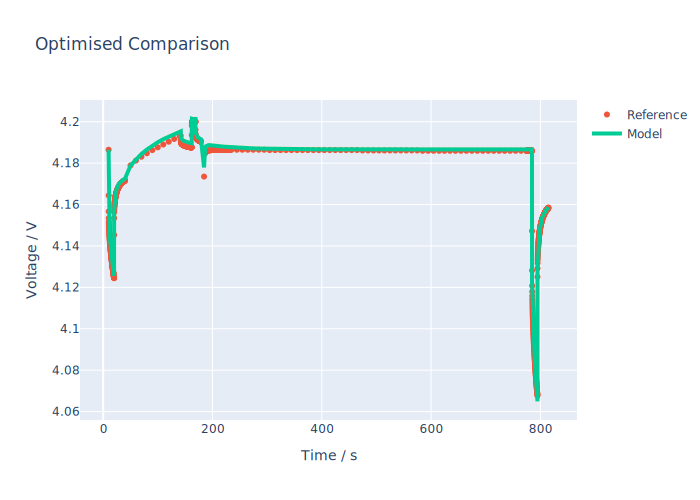

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

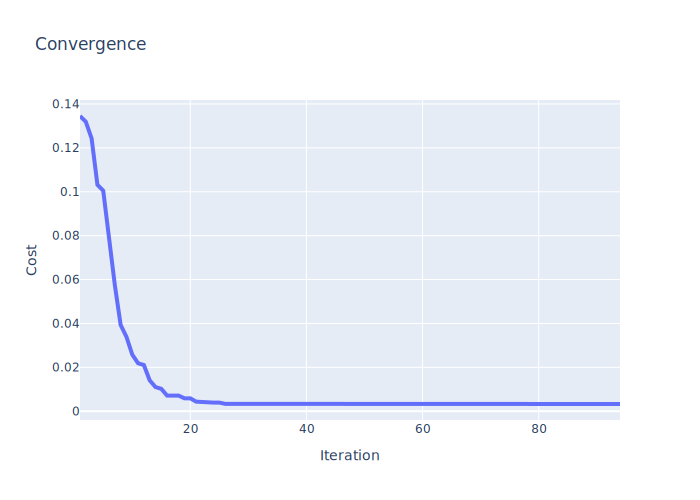

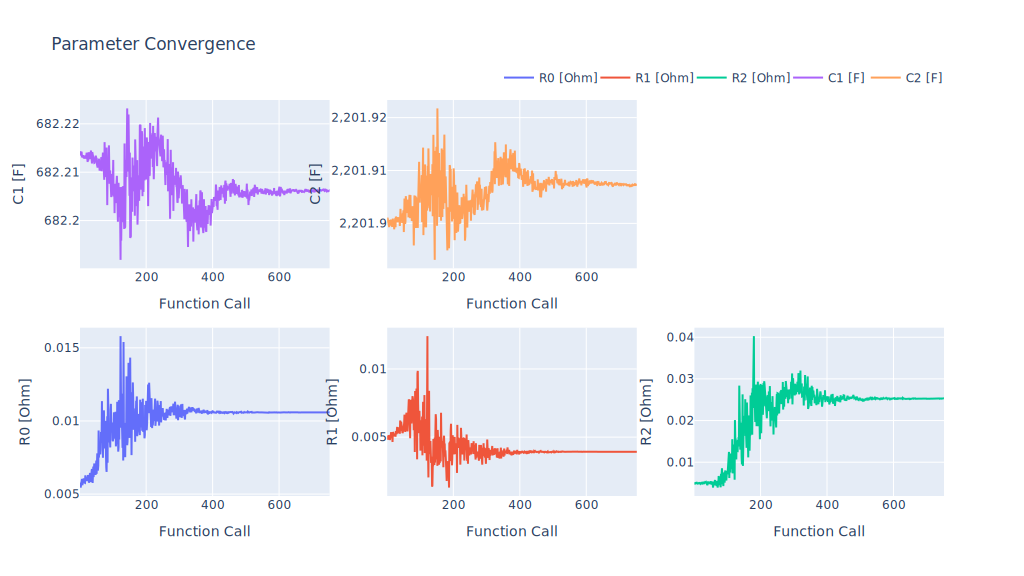

In [ ]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Conclusion

This notebook illustrates how to perform parameter estimation for multi-pulse HPPC data, providing insights into the optimisation process through various visualisations.